# DelibAnalysis Classification

The following script implements the random forests classifier in order to predict the Discourse Quality Index (DQI) category of online comments.

In [31]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [32]:
# Functions to process data

def process_labelled_data(source_csv):
    data_df = pd.read_csv(source_csv)
    indicators = ['participation', 'level_of_justification', 'content_of_justification', 'respect', 'counterarguments', 'constructive_politics']
    data_df['dqi'] = data_df[indicators].sum(axis=1)
    data_df['dqi_groups'] = data_df.dqi.map( lambda x: 0 if x <= 5 else 1 if (x > 5 and x <=10) else 2)
    data = data_df[['dqi', 'comment', 'dqi_groups','fb_comment', 'live_th', 'blog_comment']]
    return data

def comment_to_words(raw_comment):
    try:
        letters_only = re.sub("[^a-zA-Z]", " ", raw_comment)
        words = letters_only.lower().split()
        stops = set(stopwords.words("english"))
        meaningful_words = [w for w in words if not w in stops]
        return(" ".join(meaningful_words))
    except TypeError: 
        print raw_comment  

def append_features(input_matrix,input_feature):
    count = 0
    new_matrix = np.zeros(shape=(input_matrix.shape[0], input_matrix.shape[1]+1))
    for i in range(0, len(input_feature)):
        new_matrix[i] = np.append(input_matrix[i], input_feature[i])
    return new_matrix

char_dict = {'less_than_30_chars': (30,0),'between_30_and_100_chars': (100,30), 'between_100_and_300_chars': (300,100),
'between_300_and_800_chars': (800, 300), 'between_800_and_1500_chars': (1500, 800), 
'between_1500_and_3000_chars': (3000, 1500), 'more_than_3000_chars': (1000000, 3000)}

def add_character_counts(data, chars):
    data['char_count'] = data['comment'].apply(lambda x: len(x))
    for k, v in chars.items():
        data[k] = data.char_count.map(lambda x: 1 if (x <= v[0] and x > v[1]) else 0)
    return data

In [33]:
# Upload and process labelled data

labelled_data = process_labelled_data("combined_scored.csv")
labelled_data["cleaned_comment"] = labelled_data["comment"].apply(lambda x: comment_to_words(x))
labelled_data = add_character_counts(labelled_data, char_dict)
print(labelled_data.head())

   dqi                                            comment  dqi_groups  \
0  2.0                           How about lowering taxes           0   
1  2.0                              Why the interruption?           0   
2  2.0  Make it mandatory that all apartments accept p...           0   
3  1.0                                            Resign!           0   
4  1.0                           Loser PM, please go away           0   

   fb_comment  live_th  blog_comment                        cleaned_comment  \
0           1        0             0                         lowering taxes   
1           1        0             0                           interruption   
2           1        0             0  make mandatory apartments accept pets   
3           1        0             0                                 resign   
4           1        0             0                loser pm please go away   

   char_count  between_100_and_300_chars  between_300_and_800_chars  \
0          24  

In [34]:
# Train classifier 

train, test = train_test_split(labelled_data, train_size = 0.8, random_state = 44)

vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, \
                             max_features = 6000)

train_data_features = vectorizer.fit_transform(train["cleaned_comment"])
train_data_features = train_data_features.toarray()

print train_data_features.shape


quantitative_features = ["fb_comment", "live_th", "blog_comment", "less_than_30_chars", "between_30_and_100_chars",
                        "between_100_and_300_chars", "between_300_and_800_chars", "between_800_and_1500_chars",
                        "between_1500_and_3000_chars", "more_than_3000_chars"]
for i in quantitative_features:
    train_data_features = append_features(train_data_features, train[i].as_matrix())

print '(Number of comments, number of features)'
print train_data_features.shape

(576, 6000)
(Number of comments, number of features)
(576, 6010)


In [35]:
# Create the classifier
forest = RandomForestClassifier(n_jobs=-1, n_estimators=24, criterion="entropy", max_depth=17, warm_start=True, 
                                max_features=2000, bootstrap=True)
y,_ = pd.factorize(train['dqi_groups'])
forest.fit(train_data_features, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features=2000, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=24, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=True)

Feature ranking:


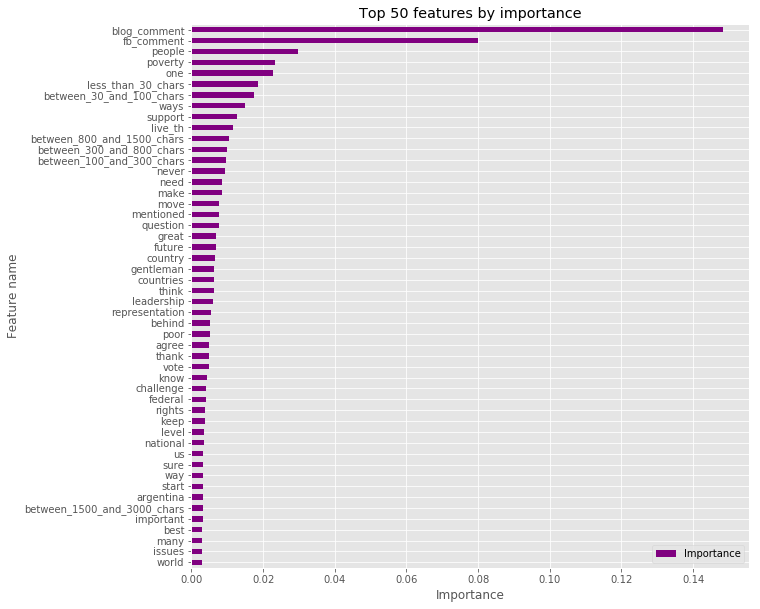

In [36]:
# View the top features used by the classifier by importance
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
vocab = vectorizer.get_feature_names()
for i in quantitative_features:
    vocab.append(i)

# Print the feature ranking
print("Feature ranking:")

feature_importance_df = pd.DataFrame(data=None, columns = ['Feature name', 'Importance'])
for f in range(0,50):
    feature_importance_df.loc[f+1] = [vocab[indices[f]], importances[indices[f]]]

plt = feature_importance_df.plot(kind="barh", figsize=(10,10), color="purple")
plt.set_yticklabels(feature_importance_df["Feature name"])
plt.invert_yaxis()
plt.set_title("Top 50 features by importance")
plt.set_xlabel("Importance")
plt.set_ylabel("Feature name")


In [37]:
# Process the test data

test_data_features = vectorizer.transform(test["cleaned_comment"])
test_data_features = test_data_features.toarray()

print test_data_features.shape

for i in quantitative_features:
    test_data_features = append_features(test_data_features, test[i].as_matrix())

print '(Number of comments, number of features)'
print test_data_features.shape

(144, 6000)
(Number of comments, number of features)
(144, 6010)


In [38]:
# Evaluate the classifier by predicting the score of the test group

result = forest.predict(test_data_features)

output = pd.DataFrame(data={"actual_dqi": test["dqi_groups"], "predicted_dqi": result})

# Create confusion matrix

print pd.crosstab(output['actual_dqi'], output['predicted_dqi'], rownames=['Actual'], \
                           colnames=['Predicted'])

print '\n*Classification Report:\n', classification_report(output['actual_dqi'], output['predicted_dqi']) 

Predicted   0   1  2
Actual              
0          76   9  1
1          12  43  0
2           0   1  2

*Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.88      0.87        86
          1       0.81      0.78      0.80        55
          2       0.67      0.67      0.67         3

avg / total       0.84      0.84      0.84       144

